## Use neural net to predict reward from observation and action to speed up the learning

In [0]:
!pip install pybullet==2.5.5

%cd /usr/local/lib/python3.6/dist-packages
!git clone https://github.com/benelot/pybullet-gym.git
%cd pybullet-gym
!pip install -e .
%cd
%cd ../content

     |████████████████████████████████| 60.4MB 64kB/s 
  Created wheel for pybullet: filename=pybullet-2.5.5-cp36-cp36m-linux_x86_64.whl size=71822399 sha256=001bbd44853b3e03acf1a1af45ab14c990eb7a583075136cb2009b7261e20dfa
  Stored in directory: /root/.cache/pip/wheels/1d/e4/cc/7b50d6689e1bc6ba07d2df04946a0eabc89deca7caed5f52d1
Successfully built pybullet
/usr/local/lib/python3.6/dist-packages
Cloning into 'pybullet-gym'...
remote: Enumerating objects: 735, done.
remote: Total 735 (delta 0), reused 0 (delta 0), pack-reused 735
Receiving objects: 100% (735/735), 19.29 MiB | 7.81 MiB/s, done.
Resolving deltas: 100% (405/405), done.
/usr/local/lib/python3.6/dist-packages/pybullet-gym
Obtaining file:///usr/local/lib/python3.6/dist-packages/pybullet-gym
  Running setup.py develop for pybulletgym
/root
/content


In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from copy import deepcopy

import gym
import pybulletgym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
from tqdm import trange
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import pickle
import pandas as pd

In [0]:
def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, requires_grad=False):
    x = torch.from_numpy(x)
    
    if requires_grad:
        return x.clone().contiguous().detach().requires_grad_(True)
    else:
        return x.clone().contiguous().detach()

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(119, 60),
            nn.Tanh(),
            nn.Linear(60, 1)
        )
        self.loss = nn.MSELoss()
        
        
    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
        

class AgentNetwork(nn.Module):
    
    def __init__(self):
        super(AgentNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(111, 100),
            nn.Tanh(),
            nn.Linear(100, 8),
            nn.Tanh()
        )

        
    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    
    def set_params(self, params):
        cpt = 0
        for param in self.parameters():
            tmp = np.product(param.size())

            if torch.cuda.is_available():
                param.data.copy_(to_tensor(
                    params[cpt:cpt + tmp]).view(param.size()).cuda())
            else:
                param.data.copy_(to_tensor(
                    params[cpt:cpt + tmp]).view(param.size()))
            cpt += tmp

            
    def get_params(self):
        return deepcopy(np.hstack([to_np(v).flatten() for v in
                                   self.parameters()]))

In [0]:
class CEM:
    
    def __init__(self, obs_std, no_params, max_steps, max_eval_steps, sigma_st, sigma_end, tau, pop_size, elitist=None):
        self.net = net
        self.max_steps = max_steps
        self.max_eval_steps = max_eval_steps
        self.sigma_st = sigma_st
        self.sigma_end = sigma_end
        self.tau = tau
        self.pop_size = pop_size
        self.elitist = elitist
        
        if self.elitist is None:
            self.elitist = int(self.pop_size//2)
        
        self.no_params = no_params
        
        self.df = pd.DataFrame({'total_steps':[], 'min_eval': [], 'mean_eval': [], 'max_eval': [], 'mean_sigma': [], 'max_sigma': []})
        
    
    def run(self):
        actor = AgentNetwork()
        
        mu = np.ones(self.no_params)
        sigma = self.sigma_st
        epsilon = 4
        
        total_steps = actor_steps = 0
        
        best, best_eval = None, -np.inf
        
        for total_steps in trange(self.max_steps, position=0, leave=True):
            if total_steps % 10 == 0:
                idx = (total_steps//10) % 10
                data = pickle.load(open(f'drive/My Drive/project_evo/data4/b{idx}.pkl', 'rb'))['X'][:, :111]
            pop = self._draw_population(mu, sigma)

            evals = np.zeros(self.pop_size)
            for i in range(self.pop_size):
                actor.set_params(pop[i])
                idxs = np.random.choice(len(data), self.max_eval_steps, replace=False)
                evals[i] = self._eval(actor, data[idxs])
            
            evals = np.maximum(0, evals)

            
            mu, sigma = self._update_params(pop, evals, mu, sigma, epsilon)
            epsilon = self.tau*epsilon + (1-self.tau)*(np.mean(self.sigma_end))
            

            if evals.max() > best_eval:
                best, best_eval = pop[np.argmax(evals)], evals.max()
                
            if total_steps % 5 == 0:
                self.df = self.df.append({'total_steps': total_steps, 'min_eval': evals.min(), 'mean_eval': evals.mean(), 'max_eval': evals.max(), 'mean_sigma': sigma.mean(), 'max_sigma': sigma.max()}, ignore_index=True)
            
            if total_steps % 100 == 0:
                to_write = {'params': {'mu': mu, 'sigma': sigma, 'epsilon': epsilon},
                           'pop': pop,
                           'best': best}
                pickle.dump(to_write, open(f'drive/My Drive/project_evo/history/try4/{total_steps}.pkl', 'w+b'), 
                            pickle.HIGHEST_PROTOCOL)
                best, best_eval = None, -np.inf
            
        return best
                
    
    def _draw_population(self, mu, sigma):
        pop = np.zeros((self.pop_size, self.no_params))
        for i in range(self.pop_size):
            pop[i] = np.random.normal(mu, np.sqrt(sigma))
        return pop

    
    def _eval(self, actor, obs):
        '''
        evals actor by generating sample from given observation distribution and use nn to predict reward based on action
        
        returns mean reward gained during eval
        '''
        # obs = torch.Tensor([np.random.normal(obs_mean, obs_std).astype(np.float32) for _ in range(self.max_eval_steps)])
        actor = AgentNetwork()
        with torch.no_grad():
            actions = actor(obs)
            obs_actions = torch.cat((obs, actions), 1)
            reward = self.net(obs_actions)
        return to_np(reward).mean()
        
    
    
    def _update_params(self, pop, evals, old_mu, old_sigma, epsilon):
        lambdas = np.array([np.log(1+self.elitist)/(1+i) for i in range(self.elitist)]).reshape(-1, 1)
        lambdas /= (lambdas.sum()+1e-10)
#         lambdas = np.full(self.elitist, 1/self.elitist)
        idxs = np.argsort(evals)[::-1][:self.elitist]
        z = pop[idxs]
        
        mu = np.sum([lambdas[i]*z[i] for i in range(self.elitist)], axis=0)

        sigma = np.sum([lambdas[i]*(z[i] - old_mu)**2 for i in range(self.elitist)], axis=0)
        sigma += epsilon
        
        sigma = np.clip(sigma, 0, 20)
        
        return mu, sigma

### Find distribution of observations to generate new similar to them

In [0]:
means, stds = [], []
for b in trange(10, position=0, leave=True):
    d = pickle.load(open(f'drive/My Drive/project_evo/data4/b{b}.pkl', 'rb'))
    X = to_np(d['X'])[:, :111]
    means.append(X.mean(axis=0))
    stds.append(X.std(axis=0))

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


In [0]:
obs_mean = np.mean(means, axis=0)
obs_std = np.mean(stds, axis=0)

In [0]:
obs = torch.Tensor([np.random.normal(obs_mean, obs_std).astype(np.float32) for _ in range(50)])
actor = AgentNetwork()
actions = actor(obs)
torch.cat((obs, actions), 1).size()

torch.Size([50, 119])

To generate new observations we'll use distribution from last batches which were recorded for quite good models.

In [0]:
net = pickle.load(open('drive/My Drive/project_evo/reward_pred/net6_cpu.pkl', 'rb'))

In [0]:
cem = CEM(net, obs_mean, obs_std, no_params=12008, max_steps=10001, max_eval_steps=350, 
          sigma_st=np.full(12008, 2), sigma_end=np.full(12008, 0.1), tau=0.99, pop_size=250)

NameError: ignored

In [0]:
best = cem.run()

NameError: ignored

In [0]:
pickle.dump(best, open('drive/My Drive/project_evo/history/try3/best.pkl', 'w+b'), pickle.HIGHEST_PROTOCOL)

In [0]:
best = pickle.load(open('drive/My Drive/project_evo/history/try2/1000.pkl', 'rb'))['best']
actor = AgentNetwork()
# actor.set_params(best)
cem._eval(actor)

1.553464

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(cem.df))*5, cem.df['mean_eval'], c='b')
plt.plot(np.arange(len(cem.df))*5, cem.df['min_eval'], c='r')
plt.plot(np.arange(len(cem.df))*5, cem.df['max_eval'], c='g')

NameError: ignored

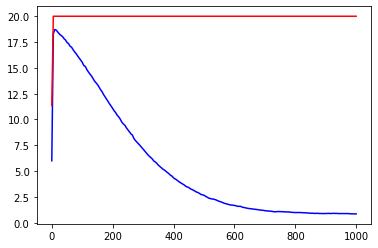

In [0]:
plt.plot(np.arange(len(cem.df))*5, cem.df['mean_sigma'], c='b')
plt.plot(np.arange(len(cem.df))*5, cem.df['max_sigma'], c='r')

### Use real collected data to train

In [0]:
net = pickle.load(open('drive/My Drive/project_evo/reward_pred/net6_cpu.pkl', 'rb'))

In [0]:
cem = CEM(net, no_params=12008, max_steps=801, max_eval_steps=1000, 
          sigma_st=np.full(12008, 2), sigma_end=np.full(12008, 0.01), tau=0.99, pop_size=150)

In [0]:
best = cem.run()

100%|██████████| 801/801 [1:01:39<00:00,  4.62s/it]


In [0]:
max_sigma, mean_sigma = [], []
for _ in range(0, 5000, 100):
    sigmas = pickle.load(open(f'drive/My Drive/project_evo/history/try4/{_}.pkl', 'rb'))['params']['sigma']
    max_sigma.append(max(sigmas))
    mean_sigma.append(np.mean(sigmas))

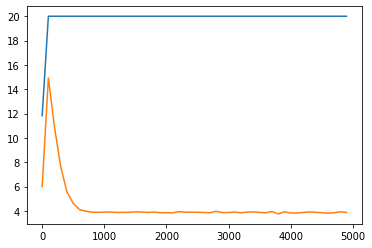

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(0, 5000, 100), max_sigma)
plt.plot(range(0, 5000, 100), mean_sigma)

### Compare predictions of net and real rewards

In [0]:
net = pickle.load(open('drive/My Drive/project_evo/reward_pred/net6_cpu.pkl', 'rb'))

#### Random agent

In [0]:
env = gym.make("AntMuJoCoEnv-v0")
env._max_episode_steps = 5000
observation = env.reset()
observation = observation.astype(np.float32)

preds, reals = [], []

for _ in trange(5000, position=0, leave=True):
    action = env.action_space.sample()
    obs_action = to_tensor(np.append(observation, action).reshape(1, -1).astype(np.float32))

    pred = net(obs_action).item()
    preds.append(pred)
    
    observation, reward, done, info = env.step(action)
    observation = observation.astype(np.float32)
    reals.append(reward)

    if done: 
        break;

env.close()
preds, reals = np.array(preds), np.array(reals)

  0%|          | 1/5000 [00:00<09:24,  8.86it/s]

current_dir=/usr/local/lib/python3.6/dist-packages/pybullet_envs/bullet
WalkerBase::__init__
options= 


100%|█████████▉| 4984/5000 [00:13<00:00, 272.10it/s]

In [0]:
np.abs(preds-reals).mean()

0.0639072683964856

In [0]:
preds.min(), preds.mean(), preds.max()

(0.39088675379753113, 0.6061707505047321, 0.8595887422561646)

In [0]:
reals.min(), reals.mean(), reals.max()

(0.2178725266232504, 0.5976706975607183, 0.918449292916921)

#### Trained agent

In [0]:
ind = pickle.load(open('drive/My Drive/project_evo/history/try1/950.pkl', 'rb'))['best']
actor = AgentNetwork()
actor.set_params(ind)

In [0]:
env = gym.make("AntMuJoCoEnv-v0")
env._max_episode_steps = 5000
observation = env.reset()
observation = to_tensor(observation.reshape(1, -1).astype(np.float32))

preds, reals = [], []


for _ in trange(5000, position=0, leave=True):
    action = actor(observation)
    action = to_np(action)[0]

    obs_action = to_tensor(np.append(observation, action).reshape(1, -1).astype(np.float32))

    pred = net(obs_action).item()
    preds.append(pred)
    
    observation, reward, done, info = env.step(action)
    observation = to_tensor(observation.reshape(1, -1).astype(np.float32))

    reals.append(reward)
    if done: 
        break;
            
env.close()
preds, reals = np.array(preds), np.array(reals)

  1%|          | 45/5000 [00:00<00:11, 447.47it/s]

WalkerBase::__init__
options= 


100%|█████████▉| 4983/5000 [00:10<00:00, 459.52it/s]

In [0]:
np.abs(preds-reals).mean()

0.059331676251239536

In [0]:
preds.min(), preds.mean(), preds.max()

(-1.535481333732605, 1.3618633848980068, 3.4622247219085693)

In [0]:
reals.min(), reals.mean(), reals.max()

(-1.6334833472268655, 1.3525770004518913, 3.5611453932215227)

In [0]:
actor

AgentNetwork(
  (layers): Sequential(
    (0): Linear(in_features=111, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=8, bias=True)
    (3): Tanh()
  )
)